# 1d Conv on EEG data

Step 1:
- build convolutional model

Step 2:
- run a training pipeline

In [2]:
import sys
sys.path.append('../')
from utils.dataset import EEGDataset
from pathlib import Path


eeg_dir = Path('../EEGDataset/')
subjects = ['sub-01']

data = EEGDataset(eeg_dir, subjects)

### Step 1 - Build model

In [3]:
import numpy as np
from sklearn import preprocessing
from utils.transforms import Compose
import torch
import torch.nn as nn 

In [4]:
class CNN(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=5, kernel_size=3),
            nn.BatchNorm1d(num_features=5),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5),
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.AvgPool1d(kernel_size=2,stride=2),
            nn.Dropout(p=0.5),
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
        )

        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=5, kernel_size=3),
            nn.LeakyReLU(),
            nn.AvgPool1d(kernel_size=35),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=5, out_features=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Initialization
        x = x.float()

        # Convolutions
        x = self.conv1(x) 
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.squeeze()

        # Fully connected layers
        x = self.fc1(x)

        return x


### Train model

In [19]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
loss_fn = nn.BCELoss()


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()                       # if not train, model won't compute gradients

    for batch_idx, batch in enumerate(dataloader):
        X = batch['eeg'].float().to(device)
        y = batch['label'].float().to(device)

        # Compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), batch_idx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch['eeg'].float().to(device)
            y = batch['label'].float().to(device)

            pred = model(X).squeeze()
            val_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss 

In [20]:
# Split data
from torch.utils.data import random_split, DataLoader
from utils.transforms import ToTensor 

scaler = data.standard_scaler()
transform = Compose([scaler, ToTensor()])

data.transform = transform

train_loader = DataLoader(data, batch_size=32)



In [21]:
lr = 1e-5
    
model = CNN(n_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.5)

epochs = 10
loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    loss.append(valid(train_loader, model, loss_fn))

print('Done!')

Epoch 1
-------------------------------
loss: 0.747399  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692802 

Epoch 2
-------------------------------
loss: 0.747298  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692801 

Epoch 3
-------------------------------
loss: 0.747289  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692801 

Epoch 4
-------------------------------
loss: 0.747303  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692801 

Epoch 5
-------------------------------
loss: 0.747285  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692801 

Epoch 6
-------------------------------
loss: 0.747270  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692801 

Epoch 7
-------------------------------
loss: 0.747262  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692800 

Epoch 8
-------------------------------
loss: 0.747256  [    0/  588]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.692800 

Epoch 9
----------------

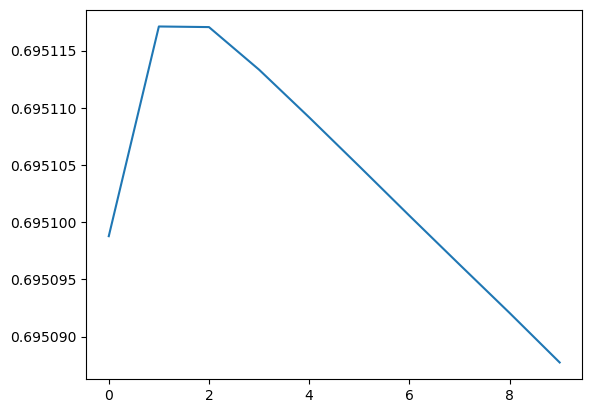

In [12]:
import matplotlib.pyplot as plt 

e = range(epochs)
plt.plot(e, loss)